In [202]:
import gdown

!gdown --id 1aUacPdKRy64Re1dy6zdyI2zLXCyZx9AV

Downloading...
From: https://drive.google.com/uc?id=1aUacPdKRy64Re1dy6zdyI2zLXCyZx9AV
To: C:\Users\Zach\Documents\GitHub\Automatic-Image-Captioning\trained_model.pt

0.00B [00:00, ?B/s]
524kB [00:00, 3.97MB/s]
1.57MB [00:00, 3.89MB/s]
2.62MB [00:00, 4.64MB/s]
3.67MB [00:00, 4.98MB/s]
4.72MB [00:00, 5.18MB/s]
5.77MB [00:01, 5.46MB/s]
6.82MB [00:01, 5.64MB/s]
7.86MB [00:01, 5.90MB/s]
8.91MB [00:01, 6.01MB/s]
9.96MB [00:01, 6.10MB/s]
11.0MB [00:01, 6.02MB/s]
12.1MB [00:02, 6.11MB/s]
13.1MB [00:02, 6.18MB/s]
14.2MB [00:02, 6.17MB/s]
15.2MB [00:02, 5.88MB/s]
16.3MB [00:02, 5.00MB/s]
17.3MB [00:03, 4.67MB/s]
17.8MB [00:03, 4.62MB/s]
18.4MB [00:03, 4.42MB/s]
18.9MB [00:03, 3.76MB/s]
19.9MB [00:03, 4.14MB/s]
21.0MB [00:03, 4.54MB/s]
21.8MB [00:04, 5.02MB/s]
22.9MB [00:04, 5.35MB/s]
23.9MB [00:04, 5.60MB/s]
25.0MB [00:04, 5.87MB/s]
26.0MB [00:04, 5.62MB/s]
27.1MB [00:05, 5.07MB/s]
28.1MB [00:05, 5.42MB/s]
29.2MB [00:05, 5.83MB/s]
30.2MB [00:05, 5.92MB/s]
31.2MB [00:05, 6.07MB/s]
32.3MB [00:05, 

In [203]:
import pickle
import skimage.io as io
import matplotlib.pyplot as plt
import nltk
import numpy as np
import csv
import torch
import torchvision.transforms as transforms

from model_factory import get_model
from file_utils import *
from pycocotools.coco import COCO
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config_data = read_file_in_dir('./', 'default.json')

vocab = pickle.load(open('savedVocab', 'rb'))

coco = COCO('./data/annotations/captions_val2014.json')

#Load IDs of test images
with open('test_ids.csv', 'r') as f:
    reader = csv.reader(f)
    testIds = list(reader)
testIds = [int(i) for i in testIds[0]]

#Load model
model = get_model(config_data, vocab)
model.load_state_dict(torch.load('trained_model.pt', map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

#Transforms for processing test images
normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
resize = transforms.Compose(
            [transforms.Resize(256, interpolation=2), transforms.CenterCrop(256)])


75.9MB [00:12, 5.43MB/s]
77.0MB [00:13, 5.02MB/s]
77.5MB [00:13, 4.64MB/s]
78.0MB [00:13, 4.34MB/s]
78.6MB [00:13, 4.35MB/s]
79.1MB [00:13, 4.35MB/s]
79.6MB [00:13, 4.31MB/s]
80.7MB [00:13, 4.58MB/s]
81.7MB [00:14, 5.00MB/s]
82.8MB [00:14, 5.25MB/s]
83.8MB [00:14, 5.50MB/s]
84.9MB [00:14, 5.72MB/s]
85.9MB [00:14, 5.98MB/s]
87.0MB [00:14, 6.03MB/s]
88.0MB [00:15, 6.31MB/s]
89.1MB [00:15, 6.39MB/s]
90.1MB [00:15, 6.47MB/s]
91.2MB [00:15, 6.47MB/s]
92.2MB [00:15, 6.28MB/s]
93.3MB [00:15, 6.54MB/s]
94.3MB [00:16, 6.71MB/s]
95.3MB [00:16, 6.89MB/s]
96.4MB [00:16, 6.84MB/s]
97.4MB [00:16, 6.59MB/s]
98.5MB [00:16, 6.74MB/s]
99.5MB [00:16, 6.78MB/s]
101MB [00:16, 6.80MB/s] 
102MB [00:17, 6.98MB/s]
103MB [00:17, 6.87MB/s]
104MB [00:17, 5.72MB/s]
105MB [00:17, 4.69MB/s]
105MB [00:17, 4.47MB/s]
106MB [00:18, 4.32MB/s]
106MB [00:18, 3.99MB/s]
107MB [00:18, 4.03MB/s]
107MB [00:18, 4.08MB/s]
108MB [00:18, 4.42MB/s]
109MB [00:18, 4.61MB/s]
110MB [00:18, 4.93MB/s]
111MB [00:19, 5.26MB/s]
112MB [00:19,

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!


In [204]:
def make_pic(tensor):
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        image = tensor * std.view(3, 1, 1)
        image = image + mean.view(3, 1, 1)
        image = torch.reshape(image, (3,256,256))
        image = image.to("cpu")
        image = transforms.ToPILImage(mode='RGB')(image)
        display(image)

def caption_to_string(caption):
    sentence = ''
    for i in range(len(caption)):
        sentence += caption[i]
        if i < len(caption) - 1 and caption[i+1][0] not in {',', '.', '\''}:
            sentence += ' '
    sentence = sentence.capitalize()
    return sentence

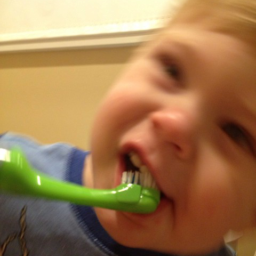

A young boy is holding a banana in his mouth


In [232]:
img = coco.loadImgs(testIds[np.random.randint(0,len(testIds))])[0]
image = io.imread(img['flickr_url'])
image = Image.fromarray(image)
image = resize(image)
image = normalize(np.asarray(image))
caption = model.predict(image.unsqueeze(0))
make_pic(image)
print(caption_to_string(caption))